In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

import matplotlib
import scipy.stats

matplotlib.rcParams.update({'font.size': 20})

model_colors = {'Species-aware':"#E69F00",'Species-agnostic':"#56B4E9",
                'Species-aware-tempscale':"#E69F00",'Species-agnostic-tempscale':"#56B4E9",
                'DNABERT':"#CC79A7", '11-mer':"#F0E442",'PhyloP100':"#0072B2",'PhyloP240':"#D55E00"}

In [2]:
#10th and 90th percentiles of reference score

percentiles_models = {"Species-agnostic":[0.166,0.552],"Species-aware":[0.167,0.552],
                      "DNABERT":[0.16,0.689],"11-mer":[0.166,0.489],"PhyloP100":[-0.877,2.03],"PhyloP241":[-0.912,3.04],} 

#1st and 99th percentiles of reference score

#percentiles_models = {"Species-agnostic":[0.0498,0.98],"Species-aware":[0.0544,0.982],"DNABERT":[0.0379,0.985],"11-mer":[0.0569,0.842],
#                      "PhyloP100":[-2.68,5.57],"PhyloP241":[-3.59,7.06],} 

In [3]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/MLM/'

In [71]:
QTL_type = 'meQTL'

In [72]:
utr_variants = pd.read_csv(data_dir + 'GRASP/model_scores.tsv.gz', sep='\t')

utr_variants = utr_variants[(utr_variants.QTL_type.isna())|(utr_variants.QTL_type==QTL_type)]

/tmp/ipykernel_2460144/52365278.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  utr_variants = pd.read_csv(data_dir + 'GRASP/model_scores.tsv.gz', sep='\t')


In [73]:
def get_contig_table(model):
    if 'Species' in model or model=='DNABERT':
        score = utr_variants[f'{model}_ref']
    else:
        score = utr_variants[model]

    perc_low, perc_high = percentiles_models[model]

    pathogenic_bottom = ((score<perc_low)&(utr_variants.label==1)).sum()
    pathogenic_top = ((score>perc_high)&(utr_variants.label==1)).sum()
    
    benign_bottom = ((score<perc_low)&(utr_variants.label==0)).sum()
    benign_top = ((score>perc_high)&(utr_variants.label==0)).sum()

    contig_table = [[pathogenic_top,benign_top], [pathogenic_bottom,benign_bottom] ]

    return contig_table, score

In [74]:
models = ('PhyloP100','PhyloP241','Species-aware','Species-agnostic','DNABERT','11-mer')

In [75]:
odds_ratios = []
score = {}

for model in models:
    contig_table, score[model] = get_contig_table(model)
    fisher_test = scipy.stats.fisher_exact(contig_table)
    print(model,contig_table, fisher_test)
    odds_ratios.append((model, fisher_test.statistic))

odds_ratios = pd.DataFrame(odds_ratios,columns=['model','OR']).sort_values(by='OR', ascending=False)
odds_ratios.loc[odds_ratios.model=='PhyloP241','model'] = 'PhyloP240'

PhyloP100 [[2, 1670], [33, 14288]] SignificanceResult(statistic=0.5185265831972419, pvalue=0.577242091722046)
PhyloP241 [[8, 2458], [24, 8803]] SignificanceResult(statistic=1.1937889883374018, pvalue=0.6688041534404492)
Species-aware [[2, 3230], [31, 17409]] SignificanceResult(statistic=0.3477279536602417, pvalue=0.15389799806309803)
Species-agnostic [[4, 3152], [30, 17475]] SignificanceResult(statistic=0.7392131979695431, pvalue=0.8107530011544374)
DNABERT [[0, 688], [9, 4526]] SignificanceResult(statistic=0.0, pvalue=0.6167508636903709)
11-mer [[10, 4163], [32, 15023]] SignificanceResult(statistic=1.127717391304348, pvalue=0.7095632450335121)


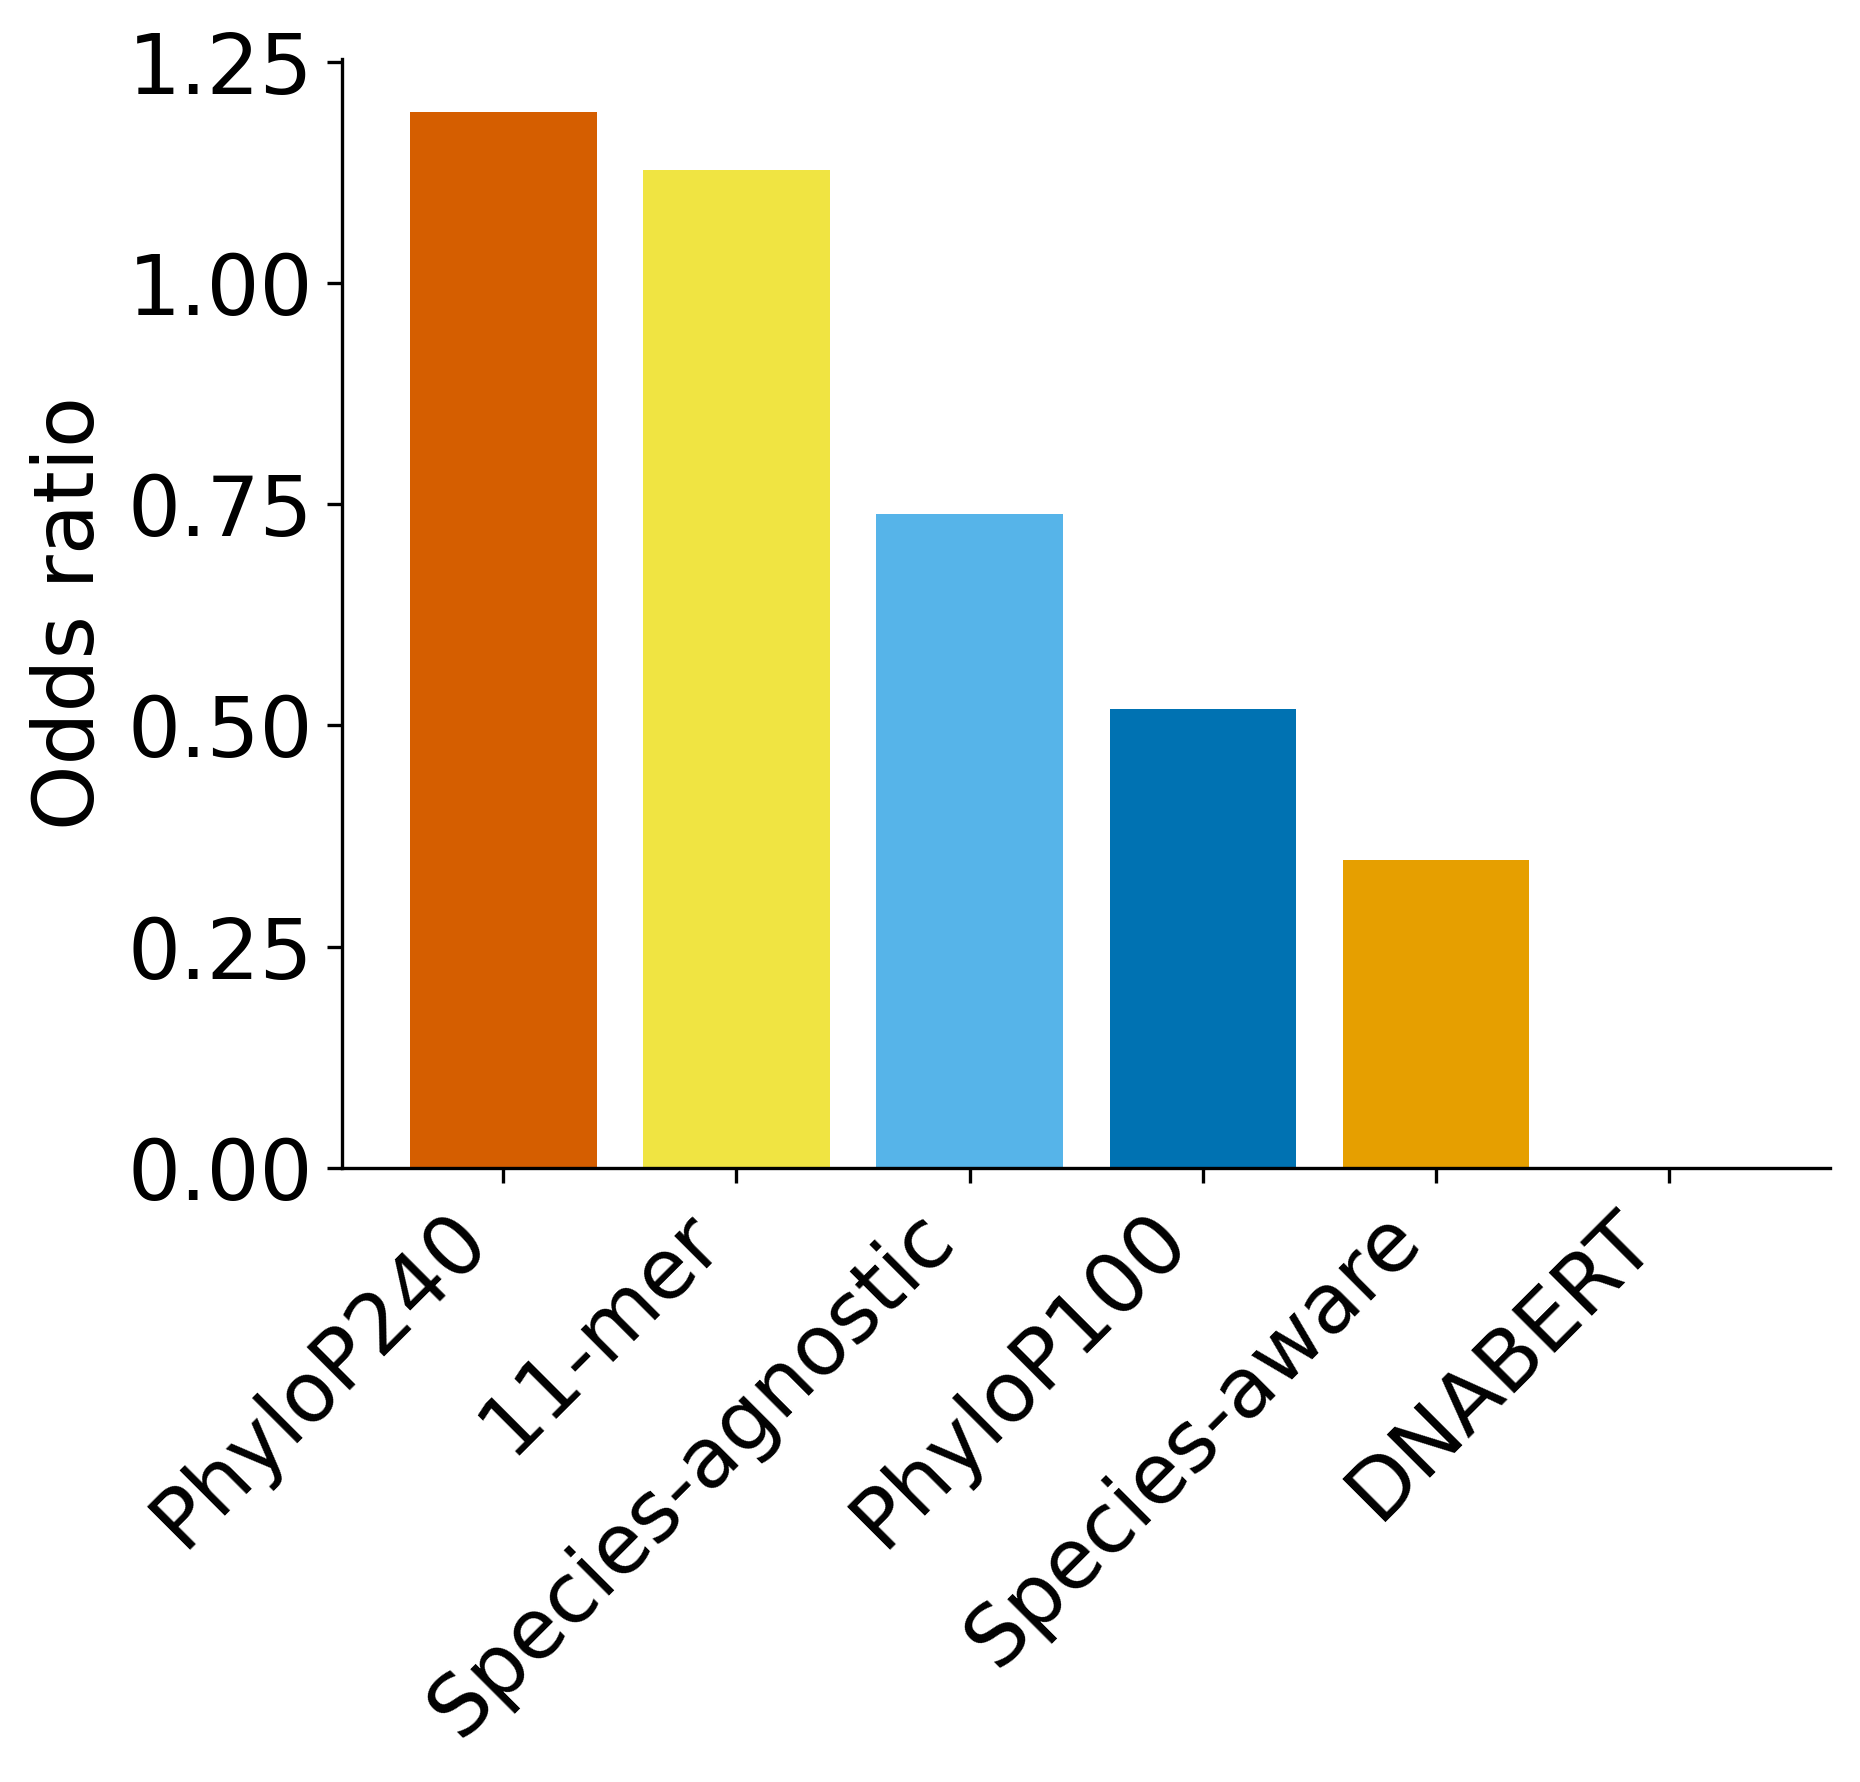

In [76]:
fig, ax = plt.subplots(dpi=300)

ax.bar(odds_ratios.model, odds_ratios.OR, color=odds_ratios.model.map(model_colors))
plt.xticks(rotation=45, ha="right")
ax.set_ylabel('Odds ratio')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_yscale('log')

#for model_idx, model in enumerate(models):
#    ax.text(model_idx-0.4, odds[model]+2, f'{odds[model]:.1f}')
#ax.set_ylim([0,260])

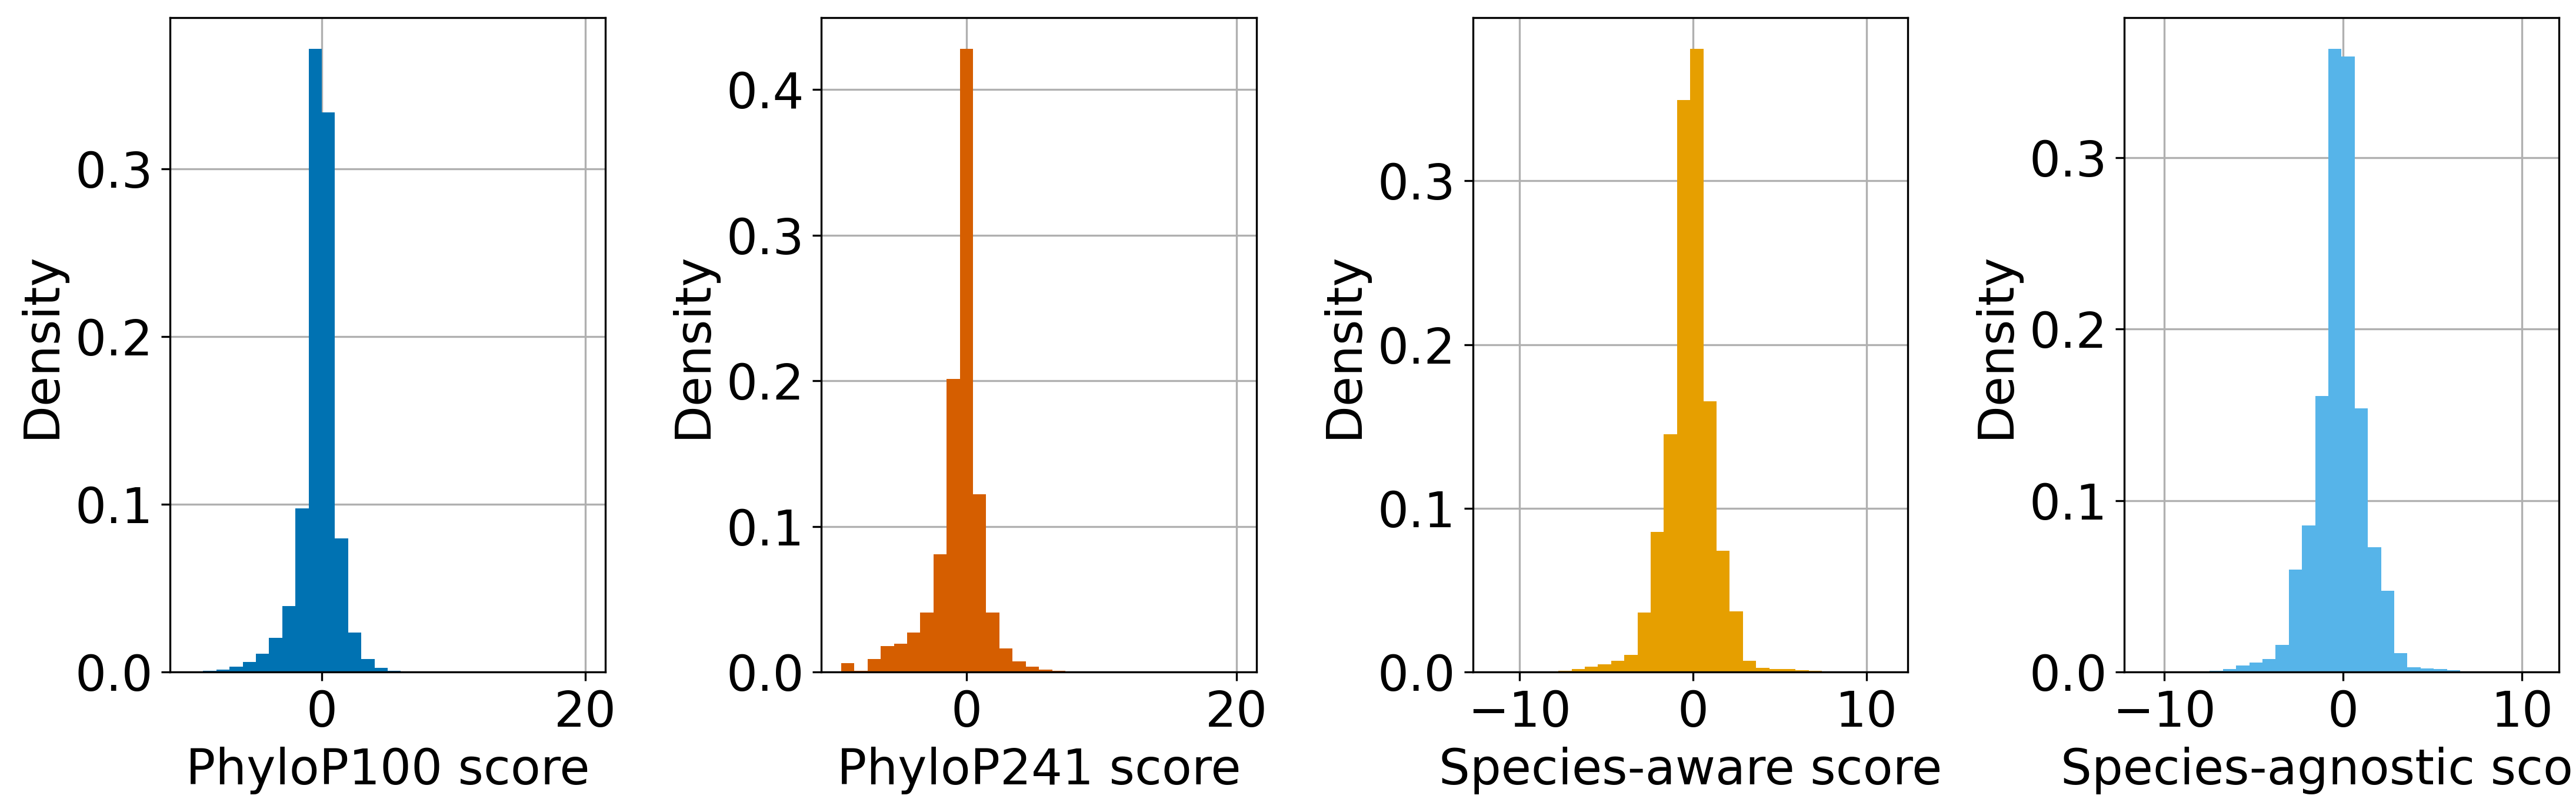

In [40]:
fig, axes = plt.subplots(1,4, figsize=(15,5), dpi=300)

for model, ax in zip(models,axes):
    ax.hist(score[model], density=True, color=model_colors[model.replace('PhyloP241','PhyloP240')], bins=30);
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_ylabel('Density')
    ax.set_xlabel(f'{model} score')


fig.tight_layout()

In [18]:
import itertools

for model1, model2 in itertools.combinations(models,2):
    mask = (~score[model1].isna()) & (~score[model2].isna())
    r = scipy.stats.pearsonr(score[model1][mask],score[model2][mask])
    print(model1, model2, r)

PhyloP100 PhyloP241 PearsonRResult(statistic=0.4876439029683529, pvalue=0.0)
PhyloP100 MLM PearsonRResult(statistic=-0.13913734561853747, pvalue=0.0)
PhyloP241 MLM PearsonRResult(statistic=-0.13405394454677214, pvalue=0.0)
